In [12]:
import numpy as np
import pylcp
import matplotlib.pyplot as plt
import scipy.stats as stat
from math import sqrt

### Hamiltonian

In [3]:
atom = pylcp.atom("41K")

In [4]:
H_g_D2, mu_q_g_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[0].J, atom.I, atom.state[0].gJ, atom.gI,
    atom.state[0].Ahfs/atom.state[2].gammaHz, Bhfs=0, Chfs=0,
    muB=1)
H_e_D2, mu_q_e_D2 = pylcp.hamiltonians.hyperfine_coupled(
    atom.state[2].J, atom.I, atom.state[2].gJ, atom.gI,
    Ahfs=atom.state[2].Ahfs/atom.state[2].gammaHz,
    Bhfs=atom.state[2].Bhfs/atom.state[2].gammaHz, Chfs=0,
    muB=1)

dijq_D2 = pylcp.hamiltonians.dqij_two_hyperfine_manifolds(
    atom.state[0].J, atom.state[2].J, atom.I)

E_e_D2 = np.unique(np.diagonal(H_e_D2))
E_g_D2 = np.unique(np.diagonal(H_g_D2))

hamiltonian_D2 = pylcp.hamiltonian(H_g_D2, H_e_D2, mu_q_g_D2, mu_q_e_D2, dijq_D2)
hamiltonian_D2.set_mass(atom.mass)

In [5]:
hamiltonian_D2.print_structure()

[[((<g|H_0|g> 8x8), (<g|mu_q|g> 8x8)) (<g|d_q|e> 8x16)]
 [(<e|d_q|g> 16x8) ((<e|H_0|e> 16x16), (<e|mu_q|e> 16x16))]]


### Beams

In [6]:
# beam parameters
s = 1.0 # intensity
det = -0.0 # detuning
alpha = 1.0

In [7]:
laserBeams_cooling_D2 = pylcp.conventional3DMOTBeams(
    s=s, delta=(E_e_D2[0] - E_g_D2[1]) + det)
laserBeams_repump_D2 = pylcp.conventional3DMOTBeams(
    s=s, delta=(E_e_D2[1] - E_g_D2[0]) + det)
laserBeams_D2 = laserBeams_cooling_D2 + laserBeams_repump_D2

### Magnetic field

In [8]:
magField = pylcp.quadrupoleMagneticField(alpha)

### Force Profile

In [9]:
x = np.arange(-5, 5.1, 0.2)
v = np.arange(-5, 5.1, 0.2)

dx = np.mean(np.diff(x))
dv = np.mean(np.diff(v))

X, V = np.meshgrid(x, v)

# Define the trap:
trap_D2 = pylcp.rateeq(
    laserBeams_D2, magField, hamiltonian_D2,
    include_mag_forces=False
)
trap_D2.generate_force_profile(
    [np.zeros(X.shape), np.zeros(X.shape), X],
    [np.zeros(V.shape), np.zeros(V.shape), V],
    name='Fz')
FzK_D2 = trap_D2.profile['Fz'].F[2]

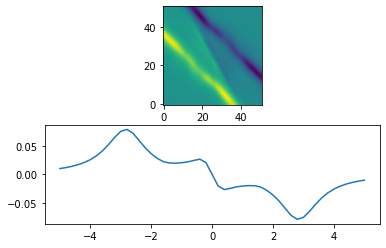

In [10]:
fig_fp, ax_fp = plt.subplots(2, 1)
ax_fp[0].imshow(FzK_D2, origin='lower')
ax_fp[1].plot(X[int(X.shape[0]/2), :],
              FzK_D2[int(X.shape[0]/2), :])

### Temperature simulation

Simulate many atoms to get the temperature. Use the Maxwell-Boltzmann distribution for the initial velocities.

In [ ]:
n_atom = 10
t = 1e-4 # evolution time
t0 = 300 # initial temp in kelvin
k = 1.38e-23
solns = [] # list of solutions to rate eq'ns

# sample velocity values from M-B dist
# also sample polar/azimuthal angles uniformly
x = stat.maxwell.rvs(size=n_atom) # maxwell-boltzmann parameter
phi = 2 * np.pi * stat.uniform.rvs(size=n_atom)
theta = np.pi * stat.uniform.rvs(size=n_atom)

# convert x to v by x = sqrt(m/kT) v
# in f(v) d^3v = (m/2Pi*kT)^(3/2) exp(-mv^2/kT) d^3v
v = sqrt(k * t0 / atom.mass) * x

for i in range(n_atom):
    
    # find intial position and velocity
    v0 = v[i] * np.array(
        [np.cos(phi[i]) * np.cos(theta[i]),
         np.cos(phi[i]) * np.sin(theta[i]),
         np.sin(phi[i])])
    x0 = np.zeros(3)
    # set up eq'n object
    eqn = pylcp.rateeq(
        laserBeams_D2, magField, hamiltonian_D2,
        include_mag_forces=True
    )
    eqn.set_initial_position_and_velocity(x0, v0)
    eqn.set_initial_pop_from_equilibrium()
    solns.append(eqn.evolve_motion(
        [0, t], freeze_axis=[False, False, False],
        random_recoil=False, random_force=False
    ))